In [1]:
import numpy as np
import pandas as pd
import pickle

import math
import json

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random
import gensim

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Train Embeddings

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()
id_word_dict = atti_dataset.get_word_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

37658

In [3]:
x_train_text = [[id_word_dict[str(x)] for x in seq if str(x) in id_word_dict] for seq in x_train]

In [4]:
model = gensim.models.Word2Vec(x_train_text, workers=5, min_count=1, iter=50)

In [5]:
model.save('../data/dataset/atti.word2vec')

In [6]:
m = gensim.models.Word2Vec.load('../data/dataset/atti.word2vec')

In [17]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in [w for w,_ in list(model.wv.vocab.items())][100:1000]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='random', n_iter=500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


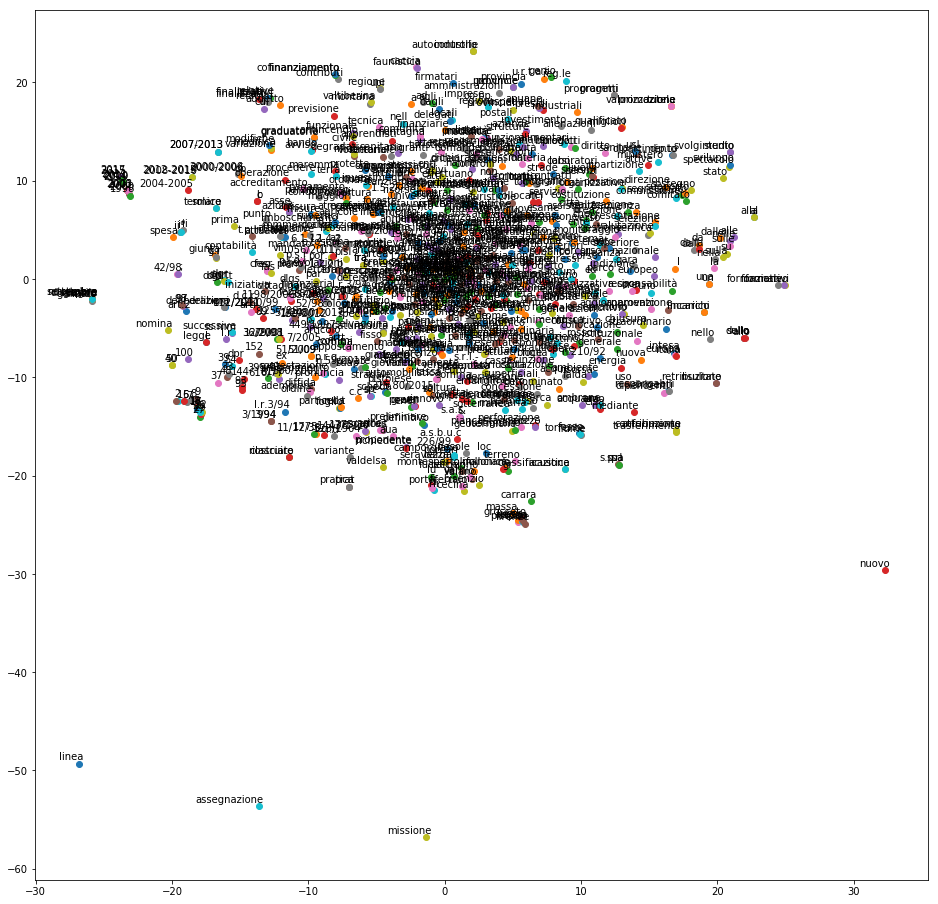

In [18]:
tsne_plot(model)

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import os

In [12]:
def visualize(model, output_path):
    meta_file = "w2x_metadata.tsv"
    placeholder = np.zeros((len(model.wv.index2word), 100))

    with open(os.path.join(output_path,meta_file), 'wb') as file_metadata:
        for i, word in enumerate(model.wv.index2word):
            placeholder[i] = model[word]
            # temporary solution for https://github.com/tensorflow/tensorflow/issues/9094
            if word == '':
                print("Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard")
                file_metadata.write("{0}".format('<Empty Line>').encode('utf-8') + b'\n')
            else:
                file_metadata.write("{0}".format(word).encode('utf-8') + b'\n')

    # define the model without training
    sess = tf.InteractiveSession()

    embedding = tf.Variable(placeholder, trainable = False, name = 'w2x_metadata')
    tf.global_variables_initializer().run()

    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(output_path, sess.graph)

    # adding into projector
    config = projector.ProjectorConfig()
    embed = config.embeddings.add()
    embed.tensor_name = 'w2x_metadata'
    embed.metadata_path = meta_file

    # Specify the width and height of a single thumbnail.
    projector.visualize_embeddings(writer, config)
    saver.save(sess, os.path.join(output_path,'w2x_metadata.ckpt'))
    print('Run `tensorboard --logdir={0}` to run visualize result on tensorboard'.format(output_path))

In [13]:
output_path = '../data/'

In [14]:
visualize(model, output_path)

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard
Run `tensorboard --logdir=../data/` to run visualize result on tensorboard
